In [1]:
!pip install oauthlib
!pip install requests_oauthlib
!pip install sentinelhub


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for sentinelhub from https://files.pythonhosted.org/packages/9e/9d/43c5e0fddf20126f0f97ee5a5d85d1948502e65b192bf3c768a42e4660ad/sentinelhub-3.10.2-py3-none-any.whl.metadata
  Obtaining dependency information for aenum>=2.1.4 from https://files.pythonhosted.org/packages/d0/fa/ca0c66b388624ba9dbbf35aab3a9f326bfdf5e56a7237fe8f1b600da6864/aenum-3.1.15-py3-none-any.whl.metadata
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
  Obtaining dependency information for dataclasses-json from https://files.pythonhosted.org/packages/92/70/382283d80cb998ebc0089428b109bbe606ec9dce891a3cb1468c03ed0ad6/dataclasses_json-0.6.6-py3-none-any.whl.metadata
  Obtaining dependency information for numpy<2 from https://files.pythonhosted.org/packages/16/2e/86f24451c2d530c88daf997cb8d6ac622c1d40d19f5a031ed68a4b73a374/numpy-1.26.4-cp312


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import pandas as pd
from PIL import Image
from datetime import datetime, timedelta

In [ ]:

# Your client credentials
client_id = 'sh-ce0eedb1-19f1-4a55-a1f9-a83e20a8e33c'
client_secret = 'VPmNjvnIF8TCcPKQ9Q6FyAEfxZbbktvq'

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)

def sentinelhub_compliance_hook(response):
    response.raise_for_status()
    return response

oauth.register_compliance_hook("access_token_response", sentinelhub_compliance_hook)


In [3]:
import requests

data = {
    "bbox": [17.995, 40.488, 17.262, 40.574],
    "datetime": "2024-04-07T00:00:00Z/2024-05-07T23:59:59Z",
    "collections": ["sentinel-1-grd", 'sentinel-2-l1c'],
    "limit": 5,
}

url = "https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/search"
response = oauth.post(url, json=data)
response.json()

{'code': 400,
 'description': "Parameter 'collections' size must be between 1 and 1."}

In [4]:
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest
config = SHConfig()
config.instance_id = '880e1fdd-9935-4a80-b200-0c1468b320a8' 
config.sh_client_secret = 'F04HuxBiCLxleKFhsTQtxXddFpx1eYo2'
config.sh_client_id = '0a9b1bb0-53eb-4a7e-b340-332a3b5c70ba'

In [71]:
fire_data = pd.read_csv("fire_data.csv")
fire_data = fire_data[["latitude", "longitude", "acq_date", "daynight"]]
print(fire_data)


   latitude  longitude    acq_date daynight
0  40.50196   17.21493  2024-05-07        N
1  40.51971   17.20793  2024-05-07        N
2  40.62622   18.00068  2024-05-07        N
3  42.57043   12.67622  2024-05-07        N
4  37.38418   15.05077  2024-05-07        N
5  38.79190   15.21219  2024-05-07        N
6  38.79254   15.21121  2024-05-07        N
7  38.79545   15.21359  2024-05-07        N
8  38.79608   15.21265  2024-05-07        N


In [91]:
def get_sentinel_image(coordinates, time_interval, config):
    padding =0.2
    bbox_coords_wgs = [coordinates[0] - padding, coordinates[1] - padding, coordinates[0] + padding, coordinates[1] + padding]
    bbox = BBox(bbox_coords_wgs, crs=CRS.WGS84)
    
    x_size = 190
    _, y_size = bbox_to_dimensions(bbox, resolution=x_size)
    eval_script = """
                //VERSION=3
                    function setup() {
                        return {
                            input: ["B02", "B03", "B04"],
                            output: { bands: 3 }
                        };
                    }
                    function evaluatePixel(sample) {
                        if (sample.CLM == 1) {
                            return [0.75 + sample.B04, sample.B03, sample.B02]
                        }
                        return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
                    }
                """
    input_data = SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(f'{time_interval[0]}T00:00:00Z', f'{time_interval[1]}T23:59:59Z'),
                )
    request = SentinelHubRequest(
        evalscript=eval_script,
        input_data=[input_data],
        responses=[SentinelHubRequest.output_response('default', MimeType.JPG)],
        bbox=bbox,
        size=(x_size, y_size),  # Pass height as a single integer
        config=config
        )   
    image = request.get_data()[0]
    return image

In [93]:
# Image.fromarray(get_sentinel_image([17.218, 40.499], "2024-05-07", config))
for index, row in fire_data.iterrows():
    day = row["acq_date"]
    day_date = datetime.strptime(day, "%Y-%m-%d")
    yesterday = (day_date - timedelta(days=1)).strftime("%Y-%m-%d")
    time_interval=(yesterday, day)
    image = get_sentinel_image([row["longitude"], row["latitude"]], time_interval, config)
    # check if image is completly black display "picture not found" and location and date, else display image
    if image.mean() == 0:
        print(f"Picture not found for location {row['latitude']}, {row['longitude']} on {row['acq_date']}")
    else:
        Image.fromarray(image).show()

Picture not found for location 40.50196, 17.21493 on 2024-05-07
Picture not found for location 40.51971, 17.20793 on 2024-05-07
Picture not found for location 40.62622, 18.00068 on 2024-05-07


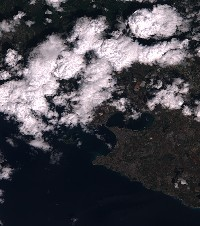

In [44]:
# Define the coordinates of the point of interest
point_coords_wgs84 = [17.218, 40.499]
padding = 0.2
# Define a small bounding box around the point of interest
bbox_coords_wgs84 = [point_coords_wgs84[0] - padding, point_coords_wgs84[1] - padding, point_coords_wgs84[0] + padding, point_coords_wgs84[1] + padding]

# Create a BBox instance
bbox = BBox(bbox_coords_wgs84, crs=CRS.WGS84)

# Define the size of the image
x_size = 200
_, y_size = bbox_to_dimensions(bbox, resolution=x_size)  # Extract height from the tuple

# Define the request
request = SentinelHubRequest(
    evalscript="""
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2024-04-07T00:00:00Z', '2024-05-07T23:59:59Z'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG)
    ],
    bbox=bbox,
    size=(x_size, y_size),  # Pass height as a single integer
    config=config
)

# Download the image
image = request.get_data()[0]

# Display the image

Image.fromarray(image)